# IV Tools – Pulsed-Field Nonlinear Transport Processing

This notebook demonstrates the use of **IV Tools**, part of the *High Magnetic Field Science Toolset* (LANL, Copyright No. C20099),
for processing non-linear transport data acquired in pulsed magnetic fields.

---

## Purpose

This notebook provides a streamlined workflow for converting raw TDMS data from NHMFL pulsed-field experiments into:
- segmented IV curves,
- background-corrected voltage–current characteristics,
- power-law fits and extracted critical currents,
- saved analysis outputs suitable for downstream plotting or aggregation.


---

## Data assumptions

This notebook assumes:
- Data are acquired using the **MAGLAB LabActor Framework**
- Raw data are stored as **TDMS** files
- Current and voltage are measured through calibrated gain chains
- Magnetic field information is provided either by:
  - PPMS metadata, or
  - an external pulsed-field trace

No manual IV segmentation is required.

---

## Software provenance

- IV Tools repository:  
  https://github.com/stef-ma/ivtools  

- High Magnetic Field Science Toolset:  
  https://github.com/ffb-LANL/High-Magnetic-Field-Science-Toolset  

LabActor is based on the National Instruments Actor Framework architecture.

---

## Processing pipeline

1. Load a TDMS file into an `IV_File` object  
2. Automatically segment the time stream into individual IV sweeps  
3. Correct linear backgrounds and suppress noise  
4. Fit non-linear regions using power-law models  
5. Save processed IV data and fit results to disk  

---

## Data flow overview

Raw TDMS data stream:

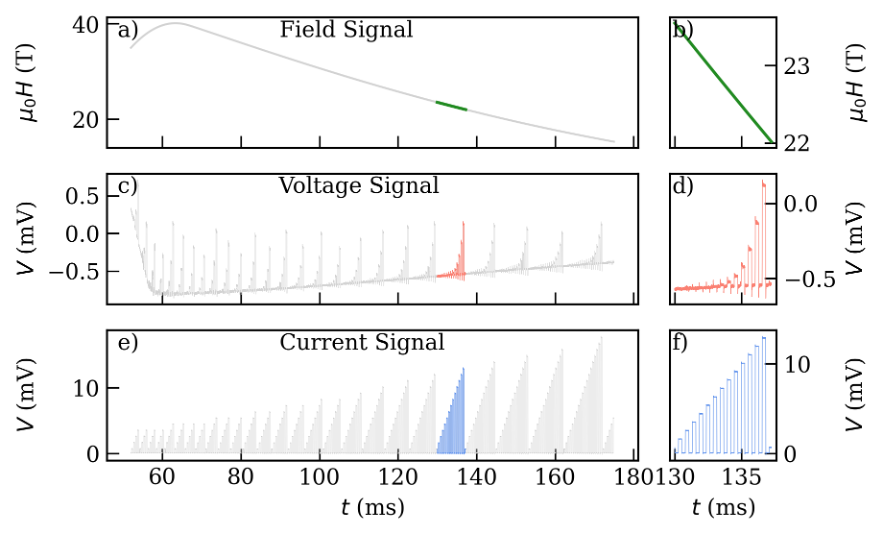

Automatic IV segmentation:

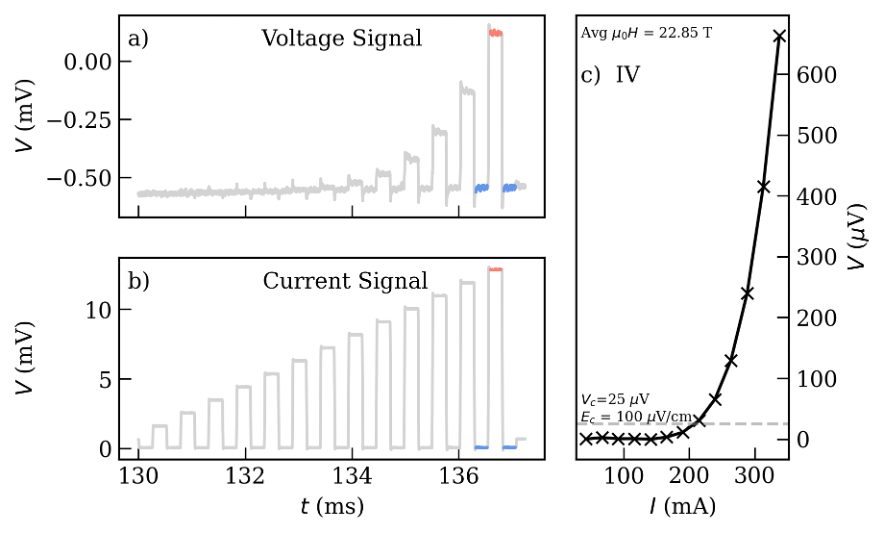

Background correction and fitting:

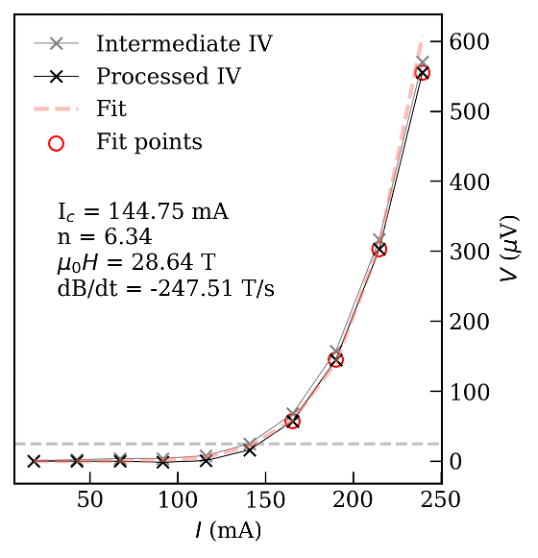

---

**Next:**  
Proceed to the next cell to define experimental parameters and load the plotting presets.


In [1]:
# presets
import matplotlib as mpl

mpl.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 6,        # Length of the major ticks
    'ytick.major.size': 6,
    'xtick.minor.visible': False, # Hide minor ticks
    'ytick.minor.visible': False,
    'axes.linewidth': 1,          # Line width of axes
    'font.family': 'serif',     # Set font
    'font.size': 11,              # Font size
})

## Load a Single IV Measurement File

In this first step, we import one IV data file into the notebook environment.  
This makes the contents of that file available in the notebook’s global namespace and allows subsequent cells to operate on this data.

**Expected behavior:**
- Reads a single IV file from a LabActor .tdms file that contains the Voltage and Current channels, as well a Field channel (if not 'PPMS' Magnet) and the LabActor Pnum and Vavg channels (specified by path or filename)
- Plots the raw and converted signals of the given IV file
- Makes the raw data object accessible for inspection and further processing

Use this when you want to test or explore a specific IV dataset before batch processing.


In [2]:
import ivtools as ivt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Widget definitions
# -----------------------------

filepath_w = widgets.Textarea(
    description="TDMS file",
    placeholder="/path/to/file.tdms",
    layout=widgets.Layout(width="80%", height="60px")
)

resistor_w = widgets.FloatText(description="Resistor (Ω)", value=1.0)
temperature_w = widgets.FloatText(description="Temperature (K)", value=77)
voltage_gain_w = widgets.FloatText(description="Voltage gain", value=1.0)
current_gain_w = widgets.FloatText(description="Current gain", value=1.0)

vchan_w = widgets.Text(description="V channel", value='V')
ichan_w = widgets.Text(description="I channel", value='I')

magnet_w = widgets.Text(description="Magnet", placeholder="e.g. Mid-Pulse or PPMS", Value='Mid Pulse')
tfield_w = widgets.FloatText(description="Target field (T)", value=0.0)

load_button = widgets.Button(description="Load IV file", button_style="primary")

t_range_w = widgets.FloatRangeSlider(
    description="Time window (s)",
    disabled=True,
    layout=widgets.Layout(width="80%"),
    continuous_update=False
)

output = widgets.Output()

# -----------------------------
# Plotting helper
# -----------------------------

def plot_raw_signals(ivf, tmin, tmax):
    mask = (ivf.t >= tmin) & (ivf.t <= tmax)

    with output:
        plt.close(plt.gcf())
        clear_output(wait=True)

        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        axs[0].plot(ivf.t[mask]*1e3, ivf.B[mask], lw= .5, color = 'black')
        axs[0].set_ylabel("B (T)")
        axs[0].set_title("Raw signals")

        axs[1].plot(ivf.t[mask]*1e3, ivf.I[mask]*1e3, lw= .1, color = 'black')
        axs[1].set_ylabel("I (mA)")
        twax = axs[1].twinx()
        twax.plot(ivf.t[mask]*1e3, ivf.I[mask]*resistor_w.value*1e6, lw= .1, color = 'black')
        twax.set_ylabel("I signal (uV)")
        

        axs[2].plot(ivf.t[mask]*1e3, ivf.V[mask]*1e6, lw= .1, color = 'black')
        axs[2].set_ylabel(r"V (uV)")
        axs[2].set_xlabel("Time (ms)")

        for ax in axs:
            ax.grid(alpha=.5)

        fig.align_labels()
        # plt.tight_layout()
        # plt.show()
        display(fig)
        # plt.close(fig)

# def plot_raw_signals(ivf, tmin, tmax):
#     mask = (ivf.t >= tmin) & (ivf.t <= tmax)

#     with output:
#         clear_output(wait=True)

#         fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

#         axs[0].plot(ivf.t[mask]*1e3, ivf.B[mask], lw=.5, color='black')
#         axs[0].set_ylabel("B (T)")
#         axs[0].set_title("Raw signals")

#         axs[1].plot(ivf.t[mask]*1e3, ivf.I[mask]*1e3, lw=.1, color='black')
#         axs[1].set_ylabel("I (mA)")
#         twax = axs[1].twinx()
#         twax.plot(
#             ivf.t[mask]*1e3,
#             ivf.I[mask]*resistor_w.value*1e6,
#             lw=.1,
#             color='black'
#         )
#         twax.set_ylabel("I signal (uV)")

#         axs[2].plot(ivf.t[mask]*1e3, ivf.V[mask]*1e6, lw=.1, color='black')
#         axs[2].set_ylabel("V (uV)")
#         axs[2].set_xlabel("Time (ms)")

#         for ax in axs:
#             ax.grid(alpha=.5)

#         fig.align_labels()
#         plt.tight_layout()

#         display(fig)
#         plt.close(fig)


# -----------------------------
# Callbacks
# -----------------------------

def load_ivf(_):
    global ivf,fp,temp

    fp = filepath_w.value
    temp = temperature_w.value

    ivf = ivt.IV_File(
        filepath_w.value,
        resistor_w.value,
        temperature_w.value,
        voltage_gain_w.value,
        current_gain_w.value,
        voltage_channel=vchan_w.value,
        current_channel=ichan_w.value,
        ppms_field=tfield_w.value if magnet_w.value == "PPMS" else None
    )

    if not ivf.passed:
        print("IV_File failed to load.")
        return

    # Initialize slider from data range
    tmin, tmax = ivf.t.min(), ivf.t.max()

    t_range_w.min = tmin
    t_range_w.max = tmax
    t_range_w.value = (tmin, tmax)
    t_range_w.step = (tmax - tmin) / 1000
    t_range_w.disabled = False

    plot_raw_signals(ivf, tmin, tmax)

    print("IV_File loaded and stored as `ivf` in workspace.")

def update_plot(change):
    if "ivf" not in globals():
        return

    tmin, tmax = change["new"]
    plot_raw_signals(ivf, tmin, tmax)


load_button.on_click(load_ivf)
t_range_w.observe(update_plot, names="value")

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        filepath_w,
        widgets.HBox([resistor_w, temperature_w]),
        widgets.HBox([voltage_gain_w, current_gain_w]),
        widgets.HBox([vchan_w, ichan_w]),
        widgets.HBox([magnet_w, tfield_w]),
        load_button,
        t_range_w,
        output
    ])
)


## Process the Imported IV File

After importing a single IV measurement, this cell applies the standard processing routines.  
This includes noise rejection, linear background subtraction, fitting the powerlaw model and computing derived quantities (e.g., critical current).

**This cell will:**
- Retrieve the imported IV object from the global namespace
- Run preprocessing steps to prepare the data (e.g., remove noise, standardize columns)
- Store processed results back into known variables for subsequent use

Run this every time after changing the IV file above to ensure consistency.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Processing parameter widgets
# -----------------------------

sample_w = widgets.Text(description="Sample", value="SampleA")
angle_w = widgets.FloatText(description="Angle (deg)", value=0.0)

voltage_criterion_w = widgets.FloatText(description="Vc (V)", value=1e-7)
noise_level_w = widgets.FloatText(description="Noise (V)", value=5e-6)

linear_sub_level_w = widgets.FloatSlider(
    description="Linearity criterion in |n-1|",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},
)

linear_sub_criterion_w = widgets.FloatSlider(
    description="Background sub strictness",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},
)

power_law_criterion_w = widgets.FloatSlider(
    description="Power-law strictness",
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.95,
    readout_format=".2f",
    continuous_update=False,
    layout=widgets.Layout(width="100%"),
    style={"description_width": "175px"},
)

minfp_w = widgets.IntText(description="min pts", value=3)
maxfp_w = widgets.IntText(description="max pts", value=30)

center_fraction_w = widgets.BoundedFloatText(
    description="Flat width fraction",
    value=0.5,
    min=0.01,
    max=0.99,
    step=0.01,
    layout=widgets.Layout(width="200px")
)

verbose_w = widgets.Checkbox(description="Verbose", value=False)

process_button = widgets.Button(
    description="Process IVs",
    button_style="danger"
)

# -----------------------------
# Plot control widgets
# -----------------------------

t_slider = widgets.FloatRangeSlider(
    description="t-range [s]",
    disabled=True,
    continuous_update=False,
    layout=widgets.Layout(width="80%")
)

show_raw_cb = widgets.Checkbox(value=True, description="Raw V")
show_proc_cb = widgets.Checkbox(value=True, description="Processed V")
show_fit_cb = widgets.Checkbox(value=True, description="Fit")
show_roi_cb = widgets.Checkbox(value=False, description="Fitted Area")

output_proc = widgets.Output()

# -----------------------------
# Plotting function
# -----------------------------

def plot_processed_iv(tlims, show_raw, show_proc, show_fit, show_roi):
    tmin, tmax = tlims

    with output_proc:
        clear_output(wait=True)

        fig = plt.figure(dpi=300, figsize=(12, 8))
        gs = fig.add_gridspec(6, 2, hspace=.05, wspace=.25)

        ax1 = fig.add_subplot(gs[0:2, 0])
        ax2 = fig.add_subplot(gs[2:4, 0])
        ax3 = fig.add_subplot(gs[4:, 0], sharex=ax1)
        twax1 = ax1.twinx()

        icax = fig.add_subplot(gs[:3, 1])
        nax = fig.add_subplot(gs[3:, 1])

        idx = (ivf.t >= tmin) & (ivf.t <= tmax)

        t_all = ivf.t * 1e3
        v_all = ivf.V * 1e3

        ax1.plot(t_all[idx], v_all[idx], lw=0.3, color="salmon")
        twax1.plot(t_all[idx], ivf.B[idx], lw=1.5, color="forestgreen")

        if show_roi:
            for _, row in ivs.dropna(subset=['lROI', 'rROI']).iterrows():
                l = int(row['lROI'])
                r = int(row['rROI'])
                if ivf.t[l] < tmin or ivf.t[r] < tmin or ivf.t[l] > tmax or ivf.t[r] > tmax:
                    continue
                else:
                    ax1.plot(t_all[l:r], v_all[l:r], lw=1.2, color="purple", alpha=0.9)

        ax1.set_ylabel("V [mV]", color="salmon")
        twax1.set_ylabel("B [T]", color='forestgreen')

        raw_labeled = False
        proc_labeled = False

        for iv_idx in ivs['IV_Index'].dropna().unique():
            split = ivs[ivs['IV_Index'] == iv_idx]

            tarr = split['Time [s]'].to_numpy()
            mask = (tarr >= tmin) & (tarr <= tmax)
            if not mask.any():
                continue

            tms = tarr[mask] * 1e3
            amps = split['Current [A]'].to_numpy()[mask] * 1e3
            volts = split['Voltage [V]'].to_numpy()[mask] * 1e3

            if show_raw:
                ax2.plot(tms, volts, marker='x', lw=.25, alpha=.5,
                         color="salmon", label='Raw' if not raw_labeled else None)
                raw_labeled = True

            if show_proc:
                proc_v = split['Processed Voltage [V]'].to_numpy()[mask] * 1e3
                ax2.plot(tms, proc_v, marker='x', lw=.5, alpha=.5,
                         color="purple", label='Processed' if not proc_labeled else None)
                proc_labeled = True

            ax3.plot(tms, amps, lw=.2, marker='o', color="black", alpha=.33)

            if show_fit:
                fit = fits[fits['IV_Index'] == iv_idx]
                if not fit.empty:
                    k = float(fit['k'].iloc[0])
                    n = float(fit['n'].iloc[0])
                    fit_y = ivt.powerlaw(amps / 1e3, k, n) * 1e3
                    ax2.plot(tms, fit_y, ls="--")

                    icax.errorbar(
                                    fit['Avg Field [T]'], 
                                    fit['I_c'] * 1e3,
                                    yerr=fit['I_c Error'],
                                    fmt='o',       # Format string for markers ('o' for circle, no line is default when using fmt)
                                    capsize=4,     # Size of the caps on the error bars
                                    elinewidth=1.5 # Thickness of the error bar lines
                                )

                    nax.errorbar(
                                    fit['Avg Field [T]'], 
                                    fit['n'],
                                    yerr=fit['n Error'],
                                    fmt='o',       # Format string for markers ('o' for circle, no line is default when using fmt)
                                    capsize=4,     # Size of the caps on the error bars
                                    elinewidth=1.5 # Thickness of the error bar lines
                                )


                    # icax.scatter(fit['Avg Field [T]'], fit['I_c'] * 1e3)
                    # nax.scatter(fit['Avg Field [T]'], fit['n'])

        ax3.set_xlabel("t [ms]")
        ax2.set_ylabel("V [mV]")
        ax2.legend(frameon=False)
        ax3.set_ylabel("I [mA]")
        ax2.set_xlim(ax3.get_xlim())
        ax2.set_xticklabels([])

        nax.set_xlabel("Field [T]")
        icax.set_ylabel("Ic [mA]")
        nax.set_ylabel("n")

        for ax in [ax1, ax2, ax3, icax, nax]:
            ax.grid(alpha=.4)

        for ax in [ax1, icax]:
            ax.xaxis.tick_top()

        for ax in [icax, nax]:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')

        plt.show()
        plt.close(fig)

# -----------------------------
# Callbacks
# -----------------------------

def run_processing(_):
    global ivs, fits, ivf

    if "ivf" not in globals():
        with output_proc:
            clear_output()
            print("No IV_File loaded.")
        return

    ivs, fits, ivf = ivt.process_ivf(
        ivf,
        filepath_w.value,
        sample_w.value,
        temperature_w.value,
        angle_w.value,
        tfield_w.value,
        voltage_criterion_w.value,
        noise_level_w.value,
        linear_sub_criterion_w.value,
        power_law_criterion_w.value,
        minfp_w.value,
        maxfp_w.value,
        magnet=magnet_w.value,
        verbose=verbose_w.value,
        lin_sub_level=linear_sub_level_w.value,
        center_fraction=center_fraction_w.value
    )

    t_slider.min = ivf.t.min()
    t_slider.max = ivf.t.max()
    t_slider.value = (ivf.t.min(), ivf.t.max())
    t_slider.step = (t_slider.max - t_slider.min) / 1000
    t_slider.disabled = False

    plot_processed_iv(
        t_slider.value,
        show_raw_cb.value,
        show_proc_cb.value,
        show_fit_cb.value,
        show_roi_cb.value
    )

def update_plot(change):
    if "ivs" not in globals():
        return

    plot_processed_iv(
        t_slider.value,
        show_raw_cb.value,
        show_proc_cb.value,
        show_fit_cb.value,
        show_roi_cb.value
    )

process_button.on_click(run_processing)

t_slider.observe(update_plot, names="value")
show_raw_cb.observe(update_plot, names="value")
show_proc_cb.observe(update_plot, names="value")
show_fit_cb.observe(update_plot, names="value")
show_roi_cb.observe(update_plot, names="value")

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        widgets.HTML("<b>IV Processing Parameters</b>"),
        widgets.HBox([sample_w, angle_w]),
        widgets.HBox([voltage_criterion_w]),
        widgets.HBox([noise_level_w]),
        widgets.HBox([linear_sub_criterion_w]),
        widgets.HBox([linear_sub_level_w]),
        widgets.HBox([power_law_criterion_w]),
        widgets.HBox([minfp_w, maxfp_w,center_fraction_w]),
        verbose_w,
        process_button,
        widgets.HTML("<hr>"),
        t_slider,
        widgets.HBox([show_raw_cb, show_proc_cb, show_fit_cb, show_roi_cb]),
        output_proc
    ])
)


## Save Processed IV Curves and Fit Results

With an IV curve processed, this cell persists the results to disk for future reference or downstream use.

This includes:
- Writing processed IV curves back to CSV using preset saving detail (see ivtools.iv_io)
- Saving any model fits (e.g. exponent fit) to CSV using the same preset detail
- Optionally storing metadata alongside numeric results (if preset="full"

**Use this to:**
- Archive analysis results
- Share individual IV outcomes with collaborators
- Prepare datasets for publication or reporting

**Note**
"Reload File Path" automatically populates the save path and filename based on the data in the global namespace.



In [8]:
import os
import ipywidgets as widgets
import pathlib
from IPython.display import display, clear_output

if 'fp' not in globals():
    fp = 'path/to/file/directory'
    fname = 'filename.tdms'
    basepath = fp
else:
    pass

fp = pathlib.Path(fp)
fname = fp.name
basepath = str(fp.parent)


#-----------------------------
# Saving widgets
# -----------------------------

savepath_w = widgets.Text(
    description="Save path",
    value=basepath,
    layout=widgets.Layout(width="80%", height="60px")
)

fname_w = widgets.Text(
    description="Filename",
    placeholder="Leave empty for original",
    value = fname
)

sample_w = widgets.Text(description="Sample")
angle_w = widgets.Text(description="Angle (deg)")

save_preset_w = widgets.Dropdown(
    description="Preset",
    options=["minimal_expanded", "minimal", "full"],
    value="full"
)

verbose_w = widgets.Checkbox(
    description="Verbose",
    value=True
)
origin_w = widgets.Checkbox(
    description="Origin?",
    value=True
)

save_iv_button = widgets.Button(
    description="Save IV data",
    button_style="success"
)

save_fit_button = widgets.Button(
    description="Save fit data",
    button_style="success"
)

save_output = widgets.Output()

# -----------------------------
# Callbacks
# -----------------------------

def save_ivdata_cb(_):
    with save_output:
        clear_output()

        if "ivs" not in globals():
            print("No `ivs` object found in workspace.")
            return

        try:
            ivt.save_ivdata(
                ivs,
                fname_w.value,
                savepath_w.value,
                sample_w.value,
                angle_w.value,
                magnet_w.value,
                tfield_w.value,
                temperature_w.value,
                preset=save_preset_w.value,
                origin=origin_w.value,
                verbose=verbose_w.value
            )
            print("IV data saved successfully.")

        except Exception as e:
            print("Failed to save IV data:")
            print(e)


def save_fitdata_cb(_):
    with save_output:
        clear_output()

        if "fits" not in globals():
            print("No `fits` object found in workspace.")
            return

        try:
            ivt.save_fitdata(
                fits,
                fname_w.value,
                savepath_w.value,
                sample_w.value,
                angle_w.value,
                magnet_w.value,
                tfield_w.value,
                temperature_w.value,
                preset=save_preset_w.value,
                origin=origin_w.value,
                verbose=verbose_w.value
            )
            print("Fit data saved successfully.")

        except Exception as e:
            print("Failed to save fit data:")
            print(e)
            
# -----------------------------
# Reload Callback
# -----------------------------

# def reload_cb(_):
    # """Reload the file path and filename from the global `fp` variable"""
    # fp = pathlib.Path(fp)
    # fname = fp.name
    # basepath = str(fp.parent)
    
    # # Update widget values dynamically
    # savepath_w.value = basepath
    # fname_w.value = fname
    
    # with save_output:
    #     clear_output()
    #     print(f"Reloaded: Path = {basepath}, Filename = {fname}")
def reload_cb(_):
    """Reload the file path and filename from the global `fp` variable"""
    global fp  # Access the global 'fp' variable
    fp = pathlib.Path(fp)  # Ensure fp is a pathlib.Path object
    fname = fp.name
    basepath = str(fp.parent)
    
    # Update widget values dynamically
    savepath_w.value = basepath
    fname_w.value = fname
    
    with save_output:
        clear_output()
        print(f"Reloaded: Path = {basepath}, Filename = {fname}")

# -----------------------------
# Wire callbacks
# -----------------------------

save_iv_button.on_click(save_ivdata_cb)
save_fit_button.on_click(save_fitdata_cb)

reload_button = widgets.Button(
    description="Reload File Path",
    button_style="info"
)
reload_button.on_click(reload_cb)

# -----------------------------
# Display layout
# -----------------------------

display(
    widgets.VBox([
        reload_button,
        widgets.HTML("<b>Save results</b>"),
        savepath_w,
        fname_w,
        widgets.HBox([sample_w, angle_w]),
        widgets.HBox([save_preset_w, verbose_w, origin_w]),
        widgets.HBox([save_iv_button, save_fit_button]),
        save_output
    ])
)


## Batch Process All IV Datasets in a Directory

This cell automates processing for all samples logged in an Excel log file and data directory.

**What it does:**
- Reads an experimental log (`.xlsx`) containing sample metadata
- Scans the associated data directory for matching IV files
- Processes each file using the same pipeline as for single imports, with a single set of parameters.
- Aggregates results (e.g., critical currents, fits, metrics) into summary tables available in the global namespace as all_ivfs, all_ivs and all_fits.

**Typical output:**
- DataFrames that combine all processing results
- Saved CSVs for IVs and fits for all applicable TDSM files

This is ideal for large datasets from a measurement session or campaign, but is limited to a single set of parameters. If needed the outputs of this may be overwritten manually with the previous cells.


In [5]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path
import ivtools as ivt
import os
from tqdm.notebook import tqdm  # for progress bar

# -----------------------------
# Widgets
# -----------------------------
logfile_w = widgets.Text(description="Excel log path", placeholder="/path/to/log.xlsx", layout=widgets.Layout(width="80%", height="40px"))
sheet_w = widgets.Text(description="Sheet:", placeholder="pulse", layout=widgets.Layout(width="20%", height="40px"))
load_log_button = widgets.Button(description="Load Excel Log", button_style="primary")
output_batch = widgets.Output()

data_root_dir_w = widgets.Text(description="Data root directory:", placeholder="/path/to/parent/directory", layout=widgets.Layout(width="80%", height="40px"))

# Metadata selectors
sample_col_w = widgets.Dropdown(description="Samples:")
angle_col_w = widgets.Dropdown(description="Angles:")
file_col_w = widgets.Dropdown(description="File names:")
magnet_col_w = widgets.Dropdown(description="Magnets:")
tfield_col_w = widgets.Dropdown(description="Target Fields:")
temp_col_w = widgets.Dropdown(description="Temperatures:")
vamp_col_w = widgets.Dropdown(description="Voltage gains:")
iamp_col_w = widgets.Dropdown(description="Current gains:")
resistor_col_w = widgets.Dropdown(description="Resistors:")

# Fit parameters
voltage_criterion_w = widgets.FloatText(description="Vc (V)", value=1e-7)
noise_level_w = widgets.FloatText(description="Noise (V)", value=5e-6)
linear_sub_level_w = widgets.FloatSlider(description="Linearity |n-1|", min=0, max=1, step=0.01, value=0.95, readout_format=".2f", layout=widgets.Layout(width="100%"))
linear_sub_criterion_w = widgets.FloatSlider(description="Background strictness", min=0, max=1, step=0.01, value=0.95, readout_format=".2f", layout=widgets.Layout(width="100%"))
power_law_criterion_w = widgets.FloatSlider(description="Power-law strictness", min=0, max=1, step=0.01, value=0.95, readout_format=".2f", layout=widgets.Layout(width="100%"))

minfp_w = widgets.IntText(description="min pts", value=3)
maxfp_w = widgets.IntText(description="max pts", value=30)
center_fraction_w = widgets.BoundedFloatText(description="Flat width fraction", value=0.5, min=0.01, max=0.99, step=0.01)

verbose_w = widgets.Checkbox(description="Verbose", value=False)
save_results_w = widgets.Checkbox(description="Save per file", value=True)

process_batch_button = widgets.Button(description="Run Batch Processing", button_style="danger")

# -----------------------------
# Saving options
# -----------------------------
save_preset_w = widgets.Dropdown(
    description="Save preset",
    options=["full", "minimal", "minimal_expanded"],
    value="full"
)
origin_w = widgets.Checkbox(
    description="Origin?",
    value=True
)

# -----------------------------
# Load Excel callback
# -----------------------------
def load_log_cb(_):
    global batch_log
    path = Path(logfile_w.value)
    with output_batch:
        clear_output(wait=True)
        if not path.exists():
            print(f"[Error] File not found: {path}")
            return
        try:
            batch_log = pd.read_excel(path, sheet_name=sheet_w.value)
        except Exception as e:
            print(f"[Error] Failed to read Excel file: {e}")
            return
        print(f"Loaded log with {len(batch_log)} rows")
        options = batch_log.columns.tolist()
        for w in [sample_col_w, angle_col_w, file_col_w, magnet_col_w, tfield_col_w, temp_col_w, vamp_col_w, iamp_col_w, resistor_col_w]:
            w.options = options
load_log_button.on_click(load_log_cb)

# -----------------------------
# Batch processing callback
# -----------------------------
def run_batch_cb(_):
    global all_ivs, all_fits, all_ivfs, batch_log
    if "batch_log" not in globals():
        with output_batch:
            clear_output()
            print("[Error] No log file loaded.")
        return

    all_ivs, all_fits, all_ivfs = [], [], {}

    # Column selections
    f_col = file_col_w.value
    s_col = sample_col_w.value
    a_col = angle_col_w.value
    m_col = magnet_col_w.value
    t_col = tfield_col_w.value
    temp_col = temp_col_w.value
    v_col = vamp_col_w.value
    i_col = iamp_col_w.value
    r_col = resistor_col_w.value

    data_root = Path(data_root_dir_w.value)
    if not data_root.exists():
        with output_batch:
            clear_output()
            print(f"[Error] Data root directory does not exist: {data_root}")
        return

    data_dirs = {d.name: d for d in data_root.iterdir() if d.is_dir()}

    with output_batch:
        clear_output(wait=True)
        print(f"Starting batch processing of {len(batch_log)} files...\n")

        for index, row in tqdm(batch_log.iterrows(), total=len(batch_log)):
            # --- File path ---
            fname = row[f_col]
            if not isinstance(fname, str) or not fname.startswith("p"):
                if verbose_w.value:
                    print(f"[Skip] Invalid filename: {fname}")
                continue

            fname_clean = fname.replace(".tdms","").replace(".","")
            day = fname_clean.split("_")[-1]
            if day not in data_dirs:
                if verbose_w.value:
                    print(f"[Warning] Day folder not found for file {fname}")
                continue

            fpath = data_dirs[day] / f"{fname_clean}.tdms"
            if not fpath.exists():
                if verbose_w.value:
                    print(f"[Warning] File does not exist: {fpath}")
                continue

            # --- Metadata ---
            sample = row[s_col]
            angle = row[a_col] if not pd.isna(row[a_col]) else 0.0
            magnet = row[m_col]
            tfield = row[t_col] if not pd.isna(row[t_col]) else 0.0
            temp = row[temp_col]
            vamp = row[v_col]
            iamp = row[i_col]
            resistor = row[r_col]

            # --- Load IV_File ---
            ivf = ivt.IV_File(fpath, resistor, temp, vamp, iamp,
                              voltage_channel="V", current_channel="I",
                              ppms_field=tfield if magnet=="PPMS" else None)
            if not ivf.passed:
                if verbose_w.value:
                    print(f"[Warning] Failed to load {fpath}")
                continue

            # --- Process ---
            try:
                ivs, fits, ivf = ivt.process_ivf(
                    ivf,
                    str(fpath),
                    sample,
                    temp,
                    angle,
                    tfield,
                    voltage_cutoff=voltage_criterion_w.value,
                    noise_level=noise_level_w.value,
                    linear_sub_criterion=linear_sub_criterion_w.value,
                    power_law_criterion=power_law_criterion_w.value,
                    minfp=minfp_w.value,
                    maxfp=maxfp_w.value,
                    magnet=magnet,
                    verbose=verbose_w.value,
                    lin_sub_level=linear_sub_level_w.value,
                    center_fraction=center_fraction_w.value
                )
            except Exception as e:
                if verbose_w.value:
                    print(f"[Error] Processing {fpath}: {e}")
                continue

            if not ivs.empty:
                all_ivs.append(ivs)
                all_ivfs[str(fpath)] = ivf
            if not fits.empty:
                all_fits.append(fits)

            # --- Save per-file results ---
            if save_results_w.value:
                save_dir = fpath.parent
                iv_filename = f"{fname_clean}"
                fit_filename = f"{fname_clean}"
                try:
                    ivt.save_ivdata(
                        ivs, iv_filename, save_dir, sample, angle,
                        magnet, tfield, temp, 
                        preset=save_preset_w.value,
                        origin=origin_w.value, 
                        verbose=verbose_w.value
                    )
                    ivt.save_fitdata(
                        fits, fit_filename, save_dir, sample, angle,
                        magnet, tfield, temp, 
                        preset=save_preset_w.value,
                        origin=origin_w.value,
                        verbose=verbose_w.value
                    )
                    if verbose_w.value:
                        print(f"[Saved] IV & FIT for {fname_clean}")
                except Exception as e:
                    if verbose_w.value:
                        print(f"[Error] Saving {fname_clean}: {e}")

        print("\nBatch processing complete.")
        print(f"Processed IVs: {len(all_ivs)}, Fits: {len(all_fits)}")

# Wire button
process_batch_button.on_click(run_batch_cb)

# -----------------------------
# Display layout
# -----------------------------
display(
    widgets.VBox([
        widgets.HTML("<b>Batch Processing</b>"),
        widgets.HBox([logfile_w, sheet_w]),
        load_log_button,
        widgets.HTML("<b>Declare root directory:</b>"),
        data_root_dir_w,
        widgets.HTML("<b>Select columns for metadata</b>"),
        widgets.HBox([file_col_w, sample_col_w, angle_col_w]),
        widgets.HBox([magnet_col_w, tfield_col_w, temp_col_w]),
        widgets.HBox([vamp_col_w, iamp_col_w, resistor_col_w]),
        widgets.HTML("<b>Fit Parameters</b>"),
        widgets.HBox([voltage_criterion_w, noise_level_w]),
        widgets.HBox([linear_sub_criterion_w, linear_sub_level_w, power_law_criterion_w]),
        widgets.HBox([minfp_w, maxfp_w, center_fraction_w]),
        widgets.HBox([verbose_w, save_results_w, save_preset_w, origin_w]),
        process_batch_button,
        output_batch
    ])
)

## Crawl Directory for CSV Results and Interactive Visualization

In this final cell, we traverse a specified root directory to locate all relevant CSV files (e.g., *_IcH_*.csv) containing Ic(H) or other curve data. We then:

- Parse metadata from file headers
- Load each dataset into a structured list or DataFrame
- Provide interactive filtering (temperature, orientation, sample)
- Display linked plots with controls for axis limits, log scaling, and filters

This interface is helpful for:
- Exploring large collections of measurement curves
- Identifying trends across conditions or samples
- Quickly comparing data subsets without writing new code

Use the terminal controls to narrow down which data to visualize.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path
import re

# -----------------------------
# Widgets
# -----------------------------
root_dir_w = widgets.Text(
    description="Root data dir:",
    placeholder="/path/to/data/root",
    layout=widgets.Layout(width="80%")
)

run_button = widgets.Button(
    description="Load & Plot Ic(H)",
    button_style="danger"
)

output_fig = widgets.Output()      # for the figure
output_ui = widgets.Output()       # for sliders and filters

# -----------------------------
# Metadata parser
# -----------------------------
def parse_header_comment(comment):
    meta = {
        "sample": None,
        "temperature": None,
        "tfield": None,
        "orientation": None,
        "magnet": None,
        "fname": None,
        "raw": None
    }

    if comment is None:
        return meta

    s = comment.lstrip("#").strip()
    meta["raw"] = s
    parts = [p.strip() for p in s.split(" | ")]

    if len(parts) >= 1:
        meta["sample"] = parts[0]
    if len(parts) >= 2:
        temp_str = parts[1].replace("p", ".").replace("K", "").strip()
        try:
            meta["temperature"] = float(temp_str)
        except ValueError:
            meta["temperature"] = temp_str
    if len(parts) >= 3:
        tfield_str = parts[2].replace("T", "").strip()
        try:
            meta["tfield"] = float(tfield_str)
        except:
            meta["tfield"] = tfield_str
    if len(parts) >= 4:
        orient_str = parts[3].replace("deg","").replace("°","").strip()
        try:
            meta["orientation"] = float(orient_str)
        except ValueError:
            meta["orientation"] = parts[3].strip()
    if len(parts) >= 5:
        meta["magnet"] = parts[4]
    if len(parts) >= 7:
        meta["fname"] = parts[6]
    elif len(parts) >= 6:
        meta["fname"] = parts[5]

    return meta

# -----------------------------
# Sort helpers
# -----------------------------
def sort_mixed_values(values):
    nums = sorted([v for v in values if isinstance(v, (int,float))])
    strs = sorted([v for v in values if isinstance(v, str)])
    return nums + strs

# -----------------------------
# Plotting function
# -----------------------------
def plot_ic(records, meta_df, xlim=None, ylim_ic=None, ylim_n=None,
            log_x=False, log_y_ic=False, log_y_n=False):
    
    fig, axes = plt.subplots(1,2,figsize=(12,6), dpi=150)
    
    # Build style maps
    temps = sort_mixed_values(meta_df["temperature"].dropna().unique())
    cmap = plt.get_cmap("tab10")
    temp_colors = {T: cmap(i % 10) for i, T in enumerate(temps)}

    marker_cycle = ["o", "s", "^", "D", "v", "P", "X", "*", "<", ">"]
    marker_map = {}
    for T in temps:
        fnames = meta_df.loc[meta_df["temperature"] == T, "fname"].unique()
        for i, fname in enumerate(fnames):
            marker_map[(T, fname)] = marker_cycle[i % len(marker_cycle)]

    orients = sort_mixed_values(meta_df["orientation"].dropna().unique())
    alpha_vals = np.linspace(1.0, 0.3, len(orients))
    orient_alpha = {o: a for o, a in zip(orients, alpha_vals)}

    # Build edge color palette for samples (up to 10 colors)
    sample_names = sort_mixed_values(meta_df["sample"].dropna().unique())
    edge_colors = ['black', 'gray', 'gainsboro', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']
    sample_styles = {s: {'edgecolor': edge_colors[i % len(edge_colors)]} for i, s in enumerate(sample_names)}

    # Plot each dataset
    for rec in records:
        df = rec["df"]
        meta = rec["meta"]

        T = meta.get("temperature")
        fname = meta.get("fname")
        orient = meta.get("orientation")
        sample = meta.get("sample")
        tfield = meta.get("tfield")

        color = temp_colors[T]
        marker = marker_map[(T, fname)]
        alpha_edge = orient_alpha[orient]

        # Get edge color for this sample
        edgecolor = sample_styles.get(sample, {'edgecolor':'black'})['edgecolor']

        label = f'{sample} | {T} K | {orient} | {tfield} T'

        for ax, y, yerr in zip(axes, ["Ic", "n"], ["Ic_err", "n_err"]):
            ax.errorbar(
                df["Field"], df[y], yerr=df[yerr],
                fmt=marker, markersize=6,
                color='none', ecolor='none',
                markerfacecolor='none', markeredgecolor='none',
                markeredgewidth=1.2, alpha=0.9,
                capsize=3
            )
            ax.scatter(
                df["Field"], df[y],
                marker=marker, s=60, facecolors=color,
                edgecolors=edgecolor, linewidths=1.5,
                alpha=alpha_edge, label=label
            )

    # Axes labels
    axes[0].set_ylabel("I_c [A]")
    axes[1].set_ylabel("n")
    for ax, title in zip(axes, ["Combined Ic(H)", "Combined n(H)"]):
        ax.set_xlabel("Field [T]")
        ax.set_title(title)
        ax.grid(alpha=0.4)

    # Apply limits
    if xlim:
        for ax in axes:
            ax.set_xlim(xlim)
    if ylim_ic:
        axes[0].set_ylim(ylim_ic)
    if ylim_n:
        axes[1].set_ylim(ylim_n)

    # Apply log scales
    axes[0].set_xscale("log" if log_x else "linear")
    axes[0].set_yscale("log" if log_y_ic else "linear")
    axes[1].set_xscale("log" if log_x else "linear")
    axes[1].set_yscale("log" if log_y_n else "linear")

    # Legend
    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    axes[1].legend(uniq.values(), uniq.keys(), fontsize=7,
                   frameon=False, bbox_to_anchor=(1.05,1), loc='upper left')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Main loader and interactive widgets
# -----------------------------
def load_and_plot_ic(_):
    root = Path(root_dir_w.value)
    with output_ui:
        clear_output(wait=True)
        print("Loading datasets...")

    if not root.exists():
        with output_ui:
            print(f"[Error] Root directory does not exist: {root}")
        return

    csv_files = sorted(root.rglob("*_IcH_*.csv"))
    if len(csv_files)==0:
        with output_ui:
            print("[Info] No *_IcH_*.csv files found.")
        return

    records = []
    for fp in csv_files:
        try:
            with open(fp,"r") as f:
                first_line = f.readline().strip()
            comment = first_line if first_line.startswith("#") else None
            meta = parse_header_comment(comment)

            df = pd.read_csv(fp, comment="#")
            if "_OriginReadable" in fp.name:
                if len(df)>=2:
                    df = df.iloc[2:].reset_index(drop=True)
                required_cols = [r"\g(m)\-(0)H", r"I\-(c)", r"I\-(c) Error","n","n Error"]
            else:
                required_cols = ["Field","Ic","Ic Error","n","n Error"]

            if not all(c in df.columns for c in required_cols):
                continue
            for c in required_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            df = df.dropna(subset=required_cols)
            df_std = pd.DataFrame({
                "Field": df[required_cols[0]],
                "Ic": df[required_cols[1]],
                "Ic_err": df[required_cols[2]],
                "n": df[required_cols[3]],
                "n_err": df[required_cols[4]]
            })
            records.append({"path":fp,"meta":meta,"df":df_std})
        except:
            continue

    if len(records)==0:
        with output_ui:
            print("[Abort] No valid datasets loaded.")
        return

    meta_df = pd.DataFrame([r["meta"] for r in records])
    globals()["ic_records"]=records
    globals()["ic_meta_df"]=meta_df

    # -----------------------------
    # Compute ranges for sliders
    # -----------------------------
    tfield_vals = pd.to_numeric(meta_df["tfield"], errors="coerce").dropna()
    field_min, field_max = tfield_vals.min(), tfield_vals.max()
    ic_vals = [r["df"]["Ic"].min() for r in records] + [r["df"]["Ic"].max() for r in records]
    ic_min, ic_max = min(ic_vals), max(ic_vals)
    n_vals = [r["df"]["n"].min() for r in records] + [r["df"]["n"].max() for r in records]
    n_min, n_max = min(n_vals), max(n_vals)

    # Sliders for plot ranges
    xlim_w = widgets.FloatRangeSlider(description="Xlim [T]", min=field_min, max=field_max,
                                      step=0.1, value=(field_min,field_max), layout=widgets.Layout(width="90%"))
    ylim_ic_w = widgets.FloatRangeSlider(description="Ylim Ic", min=ic_min, max=ic_max,
                                         step=0.001, value=(ic_min,ic_max), layout=widgets.Layout(width="90%"))
    ylim_n_w = widgets.FloatRangeSlider(description="Ylim n", min=n_min, max=n_max,
                                        step=0.1, value=(n_min, n_max), layout=widgets.Layout(width="90%"))

    # Dropdowns for filtering
    temp_options = sort_mixed_values(meta_df["temperature"].dropna().unique())
    orient_options = sort_mixed_values(meta_df["orientation"].dropna().unique())
    sample_options = sort_mixed_values(meta_df["sample"].dropna().unique())

    temp_w = widgets.SelectMultiple(options=temp_options, description="Temperature", value=tuple(temp_options), layout=widgets.Layout(width="200px"))
    orient_w = widgets.SelectMultiple(options=orient_options, description="Orientation", value=tuple(orient_options), layout=widgets.Layout(width="200px"))
    sample_w = widgets.SelectMultiple(options=sample_options, description="Sample", value=tuple(sample_options), layout=widgets.Layout(width="200px"))

    # Checkboxes for log axes
    log_x_w = widgets.Checkbox(description="Log X-axis", value=False)
    log_y_ic_w = widgets.Checkbox(description="Log Y-axis Ic", value=False)
    log_y_n_w = widgets.Checkbox(description="Log Y-axis n", value=False)

    # -----------------------------
    # Update function
    # -----------------------------
    def update_plot(*args):
        filtered = [r for r in records
                    if r["meta"]["temperature"] in temp_w.value
                    and r["meta"]["orientation"] in orient_w.value
                    and r["meta"]["sample"] in sample_w.value]

        filtered_df = pd.DataFrame([r["meta"] for r in filtered])
        with output_fig:
            clear_output(wait=True)
            if filtered:
                plot_ic(filtered, filtered_df,
                        xlim=xlim_w.value,
                        ylim_ic=ylim_ic_w.value,
                        ylim_n=ylim_n_w.value,
                        log_x=log_x_w.value,
                        log_y_ic=log_y_ic_w.value,
                        log_y_n=log_y_n_w.value)
            else:
                print("No datasets match the selected filters.")

    # Observe widgets
    for w in [xlim_w, ylim_ic_w, ylim_n_w, temp_w, orient_w, sample_w, log_x_w, log_y_ic_w, log_y_n_w]:
        w.observe(update_plot, 'value')

    # Display UI
    ui_layout = widgets.VBox([
        widgets.VBox([ylim_ic_w, xlim_w, ylim_n_w]),
        widgets.HBox([temp_w, orient_w, sample_w]),
        widgets.HBox([log_x_w, log_y_ic_w, log_y_n_w])
    ])
    with output_ui:
        display(ui_layout)

    # Initial plot
    update_plot()

# -----------------------------
# Wire callback
# -----------------------------
run_button.on_click(load_and_plot_ic)

# -----------------------------
# Display layout
# -----------------------------
display(
    widgets.VBox([
        widgets.HTML("<b>Ic(H) batch crawler + structured plotter with filters, log axes, sample edge colors</b>"),
        root_dir_w,
        run_button,
        output_ui,
        output_fig
    ])
)
